## ASTR777 Star and Planet Formation Problem Set 2
### numerically integrate the Emden-Chandrasekhar equation and plot Bonnor-Ebert density profile
$$\frac{1}{x^2}\frac{d}{dx}\left(x^2\frac{dy}{dx}\right) = e^{-y}$$

### first solution ec_integrate1 follows methodology described in the problem set
expand the differential to derive,
$$2x y' + x^2 y'' = x^2 e^{-y},$$
where $y' = dy/dx, y'' = d^2y/dx^2$. This gives a prescription for $y''$ which we can use in Taylor expansions,
$$y(x+\Delta x) = y(x) + y'(x)\Delta x + y''(x) \Delta x^2/2,$$
$$y'(x+\Delta x) = y'(x) + y''(x)\Delta x.$$
We then step out from $x=0$ to determine $y(x)$. The initial conditions are $y(0)=y'(0)=0$ (gravitational potential is zero and symmetric about the origin). We also need $y''(0)$ which is a bit tricky but we integrate once to determine $x^2y'=\int x^2e^{-y}dx\simeq x^3/3$ where the last approximation is for near the origin. This gives $y'\simeq x/3$ which implies $y''(0)=1/3$. This bit of arithmetic gymnastics mimics the more direct alternative solution below.

### alternative solution ec_integrate2 is based on https://www.youtube.com/watch?v=S0yupkDgyJk
Integrate once to,
$$x^2\frac{dy}{dx} = \int_0^x x^2e^{-y}dx \equiv f(x)$$
which then gives a prescription for a numerical solution,
$$y = \int_0^x \frac{f(x)}{x^2}dx.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
%matplotlib inline

In [2]:
def ec_integrate1(x):
    # solve Emden-Chandrasekhar equation using the way I describe in the problem set
    nsteps = x.size
    y = np.zeros(nsteps)
    yp = np.zeros(nsteps)
    yp2 = np.zeros(nsteps)

    # initial condition on d2y/dx2
    yp2[0] = 1/3

    # integrate outwards step by step (allowing for variable step size)
    for i in np.arange(1,nsteps):
        dx = x[i] - x[i-1]
        y[i] = y[i-1] + yp[i-1]*dx + yp2[i-1]*dx**2/2
        yp[i] = yp[i-1] + yp2[i-1]*dx
        yp2[i] = np.exp(-y[i]) - 2*yp[i]/x[i]

    return(y)

In [3]:
def ec_integrate2(x):
    # solve Emden-Chandrasekhar equation based on https://www.youtube.com/watch?v=S0yupkDgyJk
    nsteps = x.size
    y = np.zeros(nsteps)
    
    # initial values
    y1 = 0
    f = 0

    # integrate outwards step by step allowing for uneven step size
    for i in np.arange(1,nsteps):
        dx = x[i] - x[i-1]
        f += x[i]**2 * np.exp(-y1) * dx
        y1 += f / x[i]**2 * dx
        y[i] = y1

    return(y)

In [4]:
def plot_ec():
    # plot solution to Emden-Chandraskehar
    nsteps = 1000
    xmax = 1e4
    x = np.logspace(-2, np.log10(xmax), nsteps)
    y = ec_integrate1(x)
    #y = ec_integrate2(x)

    fig = plt.figure(figsize=(6,4))
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel(r'$x$', fontsize=14)
    ax1.set_ylabel(r'$y$', fontsize=14)
    ax1.plot(x, y, 'k-')

    ax2 = fig.add_subplot(122)
    ax2.set_xlim(1e-2, 1e4)
    ax2.set_ylim(1e-5,30)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel(r'$x$', fontsize=14)
    ax2.plot(x, y, 'k-')

    fig.tight_layout() 
    plt.savefig('ec_solution.pdf')

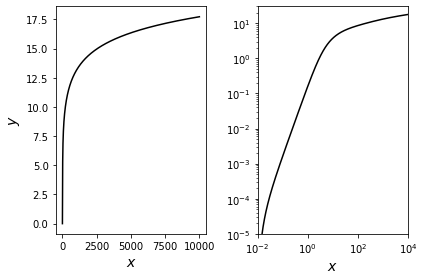

In [5]:
# part 1
plot_ec()

In [6]:
def plot_profiles():
    # plot Bonnor-Ebert density profile
    nsteps = 1000
    xmax = 1e4
    x = np.logspace(-2, np.log10(xmax), nsteps)
    y = ec_integrate1(x)
    #y = ec_integrate2(x)

    # scale for various physical parameters
    r0 = 1.243e3        # radial scale factor in pc

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)

    ax.set_xlim(0.002,1.0)
    ax.set_ylim(1e8,1e13)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'${\rm Radius}\ {\rm (pc)}$', fontsize=14)
    ax.set_ylabel(r'${\rm H_2\ density}\ {\rm (m^{-3})}$', fontsize=14)

    T = 10                                   # isothermal temperature (K)

    n0 = np.array([1,10,100,1000])*1e9       # central density in m-3
    ls = ['-','-','-','-']
    lw = [2,2,2,2]
    alpha = [0.3,0.3,0.3,0.3]

    for i in range(len(n0)):
        r = x * r0 * np.sqrt(T/n0[i])
        n = n0[i] / np.exp(y)
        ax.plot(r, n, linestyle=ls[i], color='k', lw=lw[i], alpha=alpha[i], label='Finite')

    # singular isothermal sphere
    r = np.logspace(-3,1,2)
    ax.plot(r,3.09e6*T/r**2, 'k--', lw=2, label='Singular')
    #ax.legend()

    x_labels = ['0.01','0.1','1']
    x_loc = np.array([float(x) for x in x_labels])
    ax.set_xticks(x_loc)
    ax.set_xticklabels(x_labels)

    fig.tight_layout() 
    plt.savefig('bonnor_ebert_profiles.pdf')

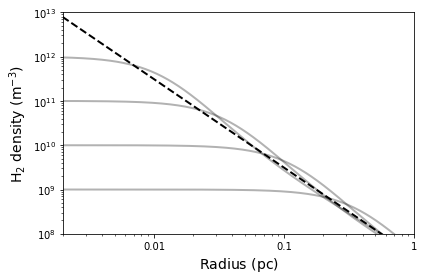

In [7]:
# part 2
plot_profiles()

In [8]:
def plot_mass():
    # plot mass for given P_ext
    nsteps = 10000
    xmax = 1e4
    x = np.logspace(-4, np.log10(xmax), nsteps)
    y = ec_integrate1(x)
    #y = ec_integrate2(x)

    T = 10              # isothermal temperature (K)
    r0 = 1.243e3        # radial scale factor in pc
    n_ext = 8e9/T       # exterior density in m-3

    n0 = np.logspace(np.log10(1.1*n_ext),12,300)
    ndens = n0.size
    r_ext = np.zeros(ndens)
    m_ext = np.zeros(ndens)
    m_tot = np.zeros(ndens)
    for i in range(ndens):
        y_ext = np.log(n0[i]/n_ext)
        j = np.where(np.abs(y/y_ext - 1) < 0.1)[0]
        ycubic = interpolate.UnivariateSpline(x[j],y[j]-y_ext)
        x_ext = ycubic.roots()[0]
        #x_ext = x[j[0]]
        k = np.where(x < x_ext)[0]
        m_ext[i] = 1.19e3 * integrate.simps(x[k]**2 / np.exp(y[k]), x[k]) * np.sqrt(T**3/n0[i])

    # max pressure contrast
    Pratio = n0/n_ext
    imax = m_ext.argmax()
    m_ext_max = m_ext[imax]
    Pratio_max = Pratio[imax]

    fig = plt.figure(figsize=(6,4))
    ax1 = fig.add_subplot(111)

    ax1.set_xlim(1,3e2)
    ax1.set_xscale('log')
    #ax1.set_yscale('log')
    ax1.set_xlabel(r'$\rho_{\rm cen}/\rho_{\rm amb}$', fontsize=14)

    ax1.set_ylim(0,6.5)
    #ax1.set_yscale('log')
    ax1.set_ylabel(r'${\rm Mass}\ (M_\odot)$', fontsize=14)
    #mplot = ax1.plot(Pratio, m_ext, 'k-', lw=3, label='Mass')

    ax1.plot(Pratio[0:imax-1], m_ext[0:imax-1], 'k-', lw=2, alpha=0.3, zorder=99)
    ax1.plot(Pratio[imax+1:], m_ext[imax+1:], 'k--', lw=2, alpha=0.3, zorder=99)
    ax1.plot(Pratio_max, m_ext_max, 'ko', markersize=4, zorder=999)
    ax1.text(2.05, 3.2, 'Stable', fontsize=12, rotation=58, backgroundcolor='white', zorder=2)
    ax1.text(50, 4.6, 'Unstable', fontsize=12, rotation=-21, zorder=2)
    ax1.text(9.5, m_ext_max+0.15, r'$M_{\rm BE}$', fontsize=12)

    # SIS
    m_SIS = 1.06 * np.sqrt(1e10/n_ext) * (T/10)**1.5
    ax1.plot([1,300], [m_SIS,m_SIS], 'k:', zorder=1)
    ax1.text(150, m_SIS-0.33, r'$M_{\rm SIS}$', fontsize=12)
    print('      M_SIS = {0:5.2f} Msun'.format(m_SIS))

    print('      M_max = {0:5.2f} Msun'.format(m_ext_max))
    print('M_max/M_SIS = {0:4.2f}'.format(m_ext_max/m_SIS))
    print('  P_0/P_ext = {0:5.2f}'.format(Pratio_max))
    ax1.plot([Pratio_max,Pratio_max], [0,10], 'k:')

    #x_labels = ['1','10','100']
    x_labels = ['1','3','10','30','100','300']
    x_loc = np.array([float(x) for x in x_labels])
    ax1.set_xticks(x_loc)
    ax1.set_xticklabels(x_labels)

    fig.tight_layout() 
    plt.savefig('bonnor_ebert_mass.pdf')

      M_SIS =  3.75 Msun
      M_max =  5.57 Msun
M_max/M_SIS = 1.49
  P_0/P_ext = 13.97


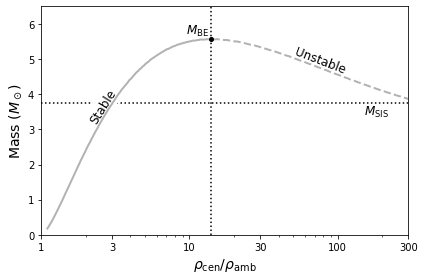

In [9]:
# part 3
plot_mass()